In [2]:
# some_file.py
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, 'ego-topo')

# import file

In [6]:
#ego-topo/blob/main/build_graph/data/epic.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tdata
import numpy as np
import os
import collections
import re
from PIL import Image, ImageOps
import glob
import ast 
import tqdm
import h5py
import re
import torchvision.models as tmodels
import copy

from build_graph.utils import util

In [3]:
!pwd

/home/nguyennguyen/Documents/egotopo


In [7]:
epic_annotations_path = "/home/nguyennguyen/Documents/egotopo/ego-topo/build_graph/data/epic/epic_data.pth"

In [8]:
def parse_annotations(data_dir):

    # get the list of object and action classes
    with open(f'{data_dir}/EPIC_verb_classes.csv') as f:
        verbs = f.read().strip().split('\n')[1:]
        verbs = [line.split(',')[1] for line in verbs]
    with open(f'{data_dir}/EPIC_noun_classes.csv') as f:
        nouns = f.read().strip().split('\n')[1:]
        nouns = [line.split(',')[1] for line in nouns]

    annotations = {'nouns':nouns, 'verbs':verbs}

    # parse the interactions
    interactions = []
    interaction_labels = open(f'{data_dir}/EPIC_train_action_labels.csv').read().strip().split('\n')[1:]
    for line in interaction_labels:
        split = line.split(',')
        v_id = split[2]
        start_time, stop_time, start, stop = split[4:8]
        verb, verb_class, noun, noun_class = split[8:12]
        interactions.append({'v_id':v_id, 'start_time':start_time, 'stop_time':stop_time, 'start':int(start), 'stop':int(stop), 'verb':int(verb_class), 'noun':int(noun_class)})
    annotations['interactions'] = interactions

    videos = set([entry['v_id'] for entry in interactions])
    annotations['videos'] = sorted(videos)

    # S1: Seen Kitchens split - 80:20 split for train/val
    vid_by_person = collections.defaultdict(list)
    for v_id in videos:
        vid_by_person[v_id.split('_')[0]].append(v_id)

    train_vids, val_vids = [], []
    for person in vid_by_person:
        vids = sorted(vid_by_person[person])
        offset = int(0.8*len(vids))
        train_vids += vids[:offset]
        val_vids += vids[offset:]
        
    annotations.update({'train_vids':train_vids, 'val_vids':val_vids})


    video_lengths = collections.defaultdict(int)
    for entry in interactions:
        video_lengths[entry['v_id']] = max(video_lengths[entry['v_id']], entry['stop'])
    annotations['vid_lengths'] = video_lengths

    torch.save(annotations, epic_annotations_path)

In [9]:

path = "/home/nguyennguyen/Documents/egotopo/ego-topo/data/epic/annotations/epic-kitchens-55-annotations"
parse_annotations(path)

In [7]:
!ln -s /home/nguyennguyen/Documents/egotopo/epic-kitchens-55-annotations /home/nguyennguyen/Documents/egotopo/ego-topo/data/epic/annotations
!ln -s /home/nguyennguyen/Documents/egotopo/P01/rgb_frames /home/nguyennguyen/Documents/egotopo/ego-topo/data/epic/frames/

ln: failed to create symbolic link '/home/nguyennguyen/Documents/egotopo/ego-topo/data/epic/annotations/epic-kitchens-55-annotations': File exists
ln: failed to create symbolic link '/home/nguyennguyen/Documents/egotopo/ego-topo/data/epic/frames/rgb_frames': File exists


In [8]:
!ls /home/nguyennguyen/Documents/egotopo/ego-topo/build_graph/data

DATASETS.md  epic  epic.py  gtea.py


In [9]:
annotations =  torch.load(epic_annotations_path)

/tmp/ipykernel_82305/1716849742.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  annotations =  torch.load(epic_annotations_path)


In [10]:
annotations

{'nouns': ['Nothing',
  'pan',
  'pan:dust',
  'tap',
  'plate',
  'knife',
  'bowl',
  'spoon',
  'cupboard',
  'drawer',
  'fridge',
  'lid',
  'hand',
  'onion',
  'onion:spring',
  'pot',
  'glass',
  'water',
  'fork',
  'board:chopping',
  'bag',
  'sponge',
  'spatula',
  'cup',
  'oil',
  'bin',
  'meat',
  'potato',
  'bottle',
  'container',
  'tomato',
  'salt',
  'cloth',
  'sink',
  'door:kitchen',
  'pasta',
  'dish:soap',
  'food',
  'kettle',
  'box',
  'carrot',
  'sauce',
  'colander',
  'milk',
  'rice',
  'garlic',
  'pepper',
  'hob',
  'dough',
  'dishwasher',
  'egg',
  'cheese',
  'bread',
  'table',
  'salad',
  'microwave',
  'oven',
  'cooker:slow',
  'coffee',
  'filter',
  'jar',
  'rack:drying',
  'chicken',
  'tray',
  'mixture',
  'towel',
  'towel:kitchen',
  'peach',
  'skin',
  'courgette',
  'liquid:washing',
  'liquid',
  'leaf',
  'lettuce',
  'leaf:mint',
  'cutlery',
  'scissors',
  'package',
  'top',
  'spice',
  'tortilla',
  'paper',
  'machi

In [1]:
import pandas as pd

df = pd.read_csv(path+"/EPIC_train_action_labels.csv")
df

NameError: name 'path' is not defined

In [12]:
#subclassing torch.utils.data.Dataset to define custom logic
class EPIC(torch.utils.data.Dataset):

    def __init__(self, root):
        super().__init__()
        self.root = root
        self.fps = 60
        
        if not os.path.exists(epic_annotations_path):
            parse_annotations(self.root)
            print ('Annotations created!')

        self.annotations =  torch.load(epic_annotations_path)
        self.interactions = self.annotations['interactions']
        self.verbs, self.nouns = self.annotations['verbs'], self.annotations['nouns']
        self.train_vids, self.val_vids = self.annotations['train_vids'], self.annotations['val_vids']

    def frame_path(self, img):
        v_id, f_id = img
        p_id = v_id.split('_')[0]
        # file = f'{self.root}/frames/train/{p_id}/{v_id}/frame_{f_id:010d}.jpg' # orig
        file = f'{self.root}/frames/train/{v_id}/frame_{f_id:010d}.jpg' # devfair
        return file        

    def load_image(self, img):
        file = self.frame_path(img)
        img = Image.open(file).convert('RGB')
        return img

In [13]:
class EPICInteractions(EPIC):

    def __init__(self, root, split, clip_len):
        super().__init__(root)

        self.split = split
        self.clip_len = clip_len

        self.train_data = self.parse_data_for_split(self.train_vids)
        self.val_data = self.parse_data_for_split(self.val_vids)
        self.data = self.train_data if self.split=='train' else self.val_data
        print (f'Train data: {len(self.train_data)} | Val data: {len(self.val_data)}')
        
        # self.clip_transform = util.clip_transform(self.split, self.clip_len)    

    def parse_data_for_split(self, videos):
        videos = set(videos)
        clips = []
        for entry in self.interactions:

            if entry['v_id'] not in videos:
                continue

            clip = dict(entry)
            frames = [(clip['v_id'], f_id) for f_id in range(clip['start'], clip['stop']+1, 2)] # frames @ 30fps
            uid = '{}_{}_{}_{}_{}'.format(clip['v_id'], clip['start_time'], clip['stop_time'], clip['verb'], clip['noun'])
            clip.update({'frames':frames, 'uid': uid})
            clips.append(clip)
        return clips

    def sample(self, imgs):
        
        if len(imgs)>self.clip_len:
            if self.split=='train': # random sample
                offset = np.random.randint(0, len(imgs)-self.clip_len)
                indices = slice(offset, offset+self.clip_len)
            elif self.split=='val': # center crop
                offset = len(imgs)//2 - self.clip_len//2
                indices = slice(offset, offset+self.clip_len)
        else:
            indices = slice(0, len(imgs))

        return indices

    def __getitem__(self, index):

        entry = self.data[index]
        frame_sample = self.sample(entry['frames'])
        frames = [self.load_image(f) for f in entry['frames'][frame_sample]]
        frames = self.clip_transform(frames) # (T, 3, 224, 224)
        frames = frames.permute(1, 0, 2, 3)
        instance = {'frames':frames, 'verb':entry['verb'], 'noun':entry['noun']}

        return instance

    def __len__(self):
        return len(self.data)


In [14]:
class EPICFrames(EPIC):

    def __init__(self, root):
        super().__init__(root)

        vid_lengths = self.annotations['vid_lengths']
        frames = []
        for v_id in vid_lengths:
            frames += [(v_id, f_id) for f_id in range(1, vid_lengths[v_id]+1)]
        self.frames = frames
        self.transform = util.default_transform('val')

        self.keys = ['%s/%d'%(v_id, f_id) for v_id, f_id in self.frames]
        self.keys = np.array(self.keys, dtype='S')

    def __getitem__(self, index):
        img = self.load_image(self.frames[index])
        img = self.transform(img)
        return {'frame': img}

    def __len__(self):
        return len(self.frames)

In [15]:
df

,uid,participant_id,video_id,narration,start_timestamp,stop_timestamp,start_frame,stop_frame,verb,verb_class,noun,noun_class,all_nouns,all_noun_classes
0,0,P01,P01_01,open door,00:00:00.14,00:00:03.37,8,202,open,2,door,8,['door'],[8]
1,1,P01,P01_01,turn on light,00:00:04.37,00:00:06.17,262,370,turn-on,12,light,113,['light'],[113]
2,2,P01,P01_01,close door,00:00:06.98,00:00:09.49,418,569,close,3,door,8,['door'],[8]
3,3,P01,P01_01,open fridge,00:00:12.77,00:00:13.99,766,839,open,2,fridge,10,['fridge'],[10]
4,4,P01,P01_01,take celery,00:00:15.25,00:00:16.40,915,983,take,0,celery,185,['celery'],[185]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28467,39232,P31,P31_14,wash glass,00:03:53.19,00:04:17.71,13991,15462,wash,4,glass,16,['glass'],[16]
28468,39233,P31,P31_14,dry hands,00:04:51.21,00:04:58.93,17472,17935,dry,11,hand,12,['hand'],[12]
28469,39234,P31,P31_14,pick up napkins,00:04:59.53,00:05:02.24,17971,18134,pick-up,0,napkin,97,['napkin'],[97]
28470,39235,P31,P31_14,put down napkins,00:05:02.34,00:05:10.76,18140,18645,put-down,1,napkin,97,['napkin'],[97]


In [16]:
#CREATE A GRAPH FROM CURRENT DATASET:
#SAMEPLE: participant 1, video1

# sub = df[(df["participant_id"]=="P01") & (df["video_id"]=="P01_01")]
sub = df[df["participant_id"]=="P01"]
sub #3089 rows of content

,uid,participant_id,video_id,narration,start_timestamp,stop_timestamp,start_frame,stop_frame,verb,verb_class,noun,noun_class,all_nouns,all_noun_classes
0,0,P01,P01_01,open door,00:00:00.14,00:00:03.37,8,202,open,2,door,8,['door'],[8]
1,1,P01,P01_01,turn on light,00:00:04.37,00:00:06.17,262,370,turn-on,12,light,113,['light'],[113]
2,2,P01,P01_01,close door,00:00:06.98,00:00:09.49,418,569,close,3,door,8,['door'],[8]
3,3,P01,P01_01,open fridge,00:00:12.77,00:00:13.99,766,839,open,2,fridge,10,['fridge'],[10]
4,4,P01,P01_01,take celery,00:00:15.25,00:00:16.40,915,983,take,0,celery,185,['celery'],[185]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3085,3991,P01,P01_19,take lid,00:07:33.82,00:07:34.60,27229,27276,take,0,lid,11,['lid'],[11]
3086,3992,P01,P01_19,close container,00:07:34.70,00:07:43.38,27282,27802,close,3,container,29,['container'],[29]
3087,3993,P01,P01_19,open fridge,00:07:46.94,00:07:48.61,28016,28116,open,2,fridge,10,['fridge'],[10]
3088,3994,P01,P01_19,close fridge,00:07:51.65,00:07:52.96,28299,28377,close,3,fridge,10,['fridge'],[10]


In [17]:
class Predicate:
    def __init__(self, name, *args):
        self.name = name
        self.args = args

    def __repr__(self):
        values = ','.join(str(v) for v in self.args if v!= None)
        return f"{self.name}({values})"

# Example usage
predicate_1 = Predicate("hasProperty", "lid", "pot")
print(predicate_1)  # Output: hasProperty(lid, pot)

hasProperty(lid,pot)


In [18]:
verbs = pd.read_csv("/home/nguyennguyen/Documents/egotopo/ego-topo/data/epic/annotations/epic-kitchens-55-annotations/EPIC_verb_classes.csv")
nouns = pd.read_csv("/home/nguyennguyen/Documents/egotopo/ego-topo/data/epic/annotations/epic-kitchens-55-annotations/Updated_EPIC_noun_classes.csv")

In [19]:
nouns

,noun_id,class_key,nouns,class
0,0,Nothing,['Nothing'],Nothing
1,1,pan,"['pan', 'pan:sauce', 'pan:frying', 'pan:cake',...",object
2,2,pan:dust,"['pan:dust', 'dustpan']",object
3,3,tap,"['tap', 'tap:water', 'nozzle', 'nozzle:coffee']",object
4,4,plate,"['plate', 'plate:pasta', 'saucer', 'dish', 'pl...",object
...,...,...,...,...
347,347,heart,['heart'],object
348,348,funnel,['funnel'],object
349,349,whisk,['whisk'],object
350,350,driver:screw,['driver:screw'],object


In [20]:
verbs.loc[verbs["verb_id"]==0, "class_key"].iloc[0]
# verbs.loc[verbs["verb_id"]==0]

'take'

In [21]:
noun_ids = sub["noun_class"].tolist()
verb_ids = sub["verb_class"].tolist()

In [22]:
objects = []
actions = []
#look up the class names of nouns and verbs IDs. For illustration purpose, but eventually will use ids 
for i in noun_ids:
    obj = nouns.loc[nouns["noun_id"] == i, "class_key"].iloc[0]
    objects.append(obj)

for i in verb_ids:
    obj = verbs.loc[verbs["verb_id"] == i, "class_key"].iloc[0]
    actions.append(obj)

In [23]:
len(noun_ids)

3090

In [24]:
startfs = sub["start_frame"].tolist()
stopfs = sub["stop_frame"].tolist()

#create tuple of (start_frame, stop_frame) for each interaction
timeframe = list(zip(startfs, stopfs))

timeframe

[(8, 202),
 (262, 370),
 (418, 569),
 (766, 839),
 (915, 983),
 (990, 1083),
 (1091, 1268),
 (1314, 1399),
 (1390, 1457),
 (1468, 1676),
 (1498, 1572),
 (1753, 1879),
 (2200, 2266),
 (2507, 2553),
 (2592, 2798),
 (2787, 2868),
 (2865, 2925),
 (3099, 3180),
 (3210, 3360),
 (3213, 3261),
 (3283, 3344),
 (3366, 3396),
 (3447, 3522),
 (3543, 3738),
 (3711, 3913),
 (3912, 4387),
 (4457, 4733),
 (4739, 4967),
 (4931, 4991),
 (5129, 5189),
 (5245, 5297),
 (5551, 5645),
 (5716, 5973),
 (6044, 6135),
 (6099, 6144),
 (6181, 6226),
 (6246, 6313),
 (6341, 7321),
 (7327, 7618),
 (7668, 8693),
 (7859, 8747),
 (9031, 9939),
 (9945, 10816),
 (10822, 11634),
 (14342, 14928),
 (15003, 15472),
 (15701, 15878),
 (15903, 15986),
 (16114, 16154),
 (16225, 16329),
 (16324, 16671),
 (16776, 16881),
 (16887, 16975),
 (16968, 17103),
 (17109, 17207),
 (17271, 17655),
 (17661, 17736),
 (17742, 17982),
 (18075, 18930),
 (18078, 18207),
 (18213, 18929),
 (18901, 18956),
 (19095, 19200),
 (19366, 19690),
 (19696, 2

In [27]:
#Create Affordance(obj, action)
# Action(object, action, time)
def create_affordance_pred(obj, verb):
   return Predicate("Affordance", str(obj), str(verb))

def create_action_pred(obj, verb, time=None):
    return Predicate("Action", str(obj), str(verb), time)

def create_action_indirect_pred(obj1, verb, obj2, time=None):
    return Predicate("ActionIndirect", str(obj1), str(verb), str(obj2), time)

def create_property_pred(obj1, obj2):
    return Predicate("HadProperty", str(obj1), str(obj2))

def lookup_noun(idx):
    noun = nouns.loc[nouns["noun_id"] == idx, "class_key"].iloc[0]
    return noun

def lookup_verb(idx):
    verb = verbs.loc[verbs["verb_id"] == idx, "class_key"].iloc[0]
    return verb

In [28]:
#Create hasProperty() predicate [[], [hasProperty(x,y)], [],[]]
#TODO: Implement ActionIndirect(obj, action, obj2, time)

import ast
classes = sub["all_noun_classes"].apply(ast.literal_eval)

#Create empty list of predicates
predicates = [[] for _ in range(len(sub))]
preds_notime = [[] for _ in range(len(sub))]

for idx, row in enumerate(classes):
    pred = []
    pred_notime = []
    if len(row) > 1:
        arg1 = ""
        arg2 = ""
        for noun_id in row:
            class_type = nouns.loc[nouns["noun_id"]== noun_id, "class"].iloc[0]
            if class_type == "property":
                arg1 = noun_id
            else:
                if arg2 == "":
                    arg2 = noun_id
                else:
                    obj1 = lookup_noun(arg2)
                    obj2 = lookup_noun(noun_id)
                    indirect_pred = create_action_indirect_pred(obj1, actions[idx], obj2, timeframe[idx])
                    pred.extend([indirect_pred])

                    # indirect_notime = create_action_indirect_pred(obj1, actions[idx], obj2)
                    pred_notime.extend([("ActionIndirect", obj1, actions[idx], obj2)])
                    
        if arg1:
            arg1_noun = lookup_noun(arg1)
            arg2_noun = lookup_noun(arg2)
            property_pred = create_property_pred(str(arg1_noun), str(arg2_noun))
            pred.extend([property_pred])

            pred_notime.extend([("HasProperty", arg1_noun, arg2_noun)])

            
    else:
        noun = lookup_noun(row[0])
        action = actions[idx]
        action_pred = create_action_pred(noun, action, timeframe[idx])
        afford_pred = create_affordance_pred(noun, action)
        pred.extend([action_pred, afford_pred])

        # action_notime = create_action_pred(noun, action)
        # afford_notime = create_affordance_pred(noun, action)
        pred_notime.extend([("Action", noun, action), ("Affordance", noun, action)])

    predicates[idx].extend(pred)
    preds_notime[idx].extend(pred_notime)

predicates

[[Action(cupboard,open,(8, 202)), Affordance(cupboard,open)],
 [Action(light,turn-on,(262, 370)), Affordance(light,turn-on)],
 [Action(cupboard,close,(418, 569)), Affordance(cupboard,close)],
 [Action(fridge,open,(766, 839)), Affordance(fridge,open)],
 [Action(celery,take,(915, 983)), Affordance(celery,take)],
 [Action(container,take,(990, 1083)), Affordance(container,take)],
 [Action(tofu,take,(1091, 1268)), Affordance(tofu,take)],
 [Action(fridge,close,(1314, 1399)), Affordance(fridge,close)],
 [Action(fridge,open,(1390, 1457)), Affordance(fridge,open)],
 [Action(carrot,take,(1468, 1676)), Affordance(carrot,take)],
 [Action(drawer,open,(1498, 1572)), Affordance(drawer,open)],
 [Action(fridge,close,(1753, 1879)), Affordance(fridge,close)],
 [Action(vegetable,put,(2200, 2266)), Affordance(vegetable,put)],
 [Action(cupboard,open,(2507, 2553)), Affordance(cupboard,open)],
 [Action(board:chopping,take,(2592, 2798)), Affordance(board:chopping,take)],
 [Action(board:chopping,put,(2787, 2868

In [32]:
#ENTRIES FROM THE DATA
entries = preds_notime

In [33]:
new_df = pd.DataFrame({'object':objects, 'action':actions, 'time':timeframe, 'ground_atoms':predicates})
new_df

,object,action,time,ground_atoms
0,cupboard,open,"(8, 202)","[Action(cupboard,open,(8, 202)), Affordance(cu..."
1,light,turn-on,"(262, 370)","[Action(light,turn-on,(262, 370)), Affordance(..."
2,cupboard,close,"(418, 569)","[Action(cupboard,close,(418, 569)), Affordance..."
3,fridge,open,"(766, 839)","[Action(fridge,open,(766, 839)), Affordance(fr..."
4,celery,take,"(915, 983)","[Action(celery,take,(915, 983)), Affordance(ce..."
...,...,...,...,...
3085,lid,take,"(27229, 27276)","[Action(lid,take,(27229, 27276)), Affordance(l..."
3086,container,close,"(27282, 27802)","[Action(container,close,(27282, 27802)), Affor..."
3087,fridge,open,"(28016, 28116)","[Action(fridge,open,(28016, 28116)), Affordanc..."
3088,fridge,close,"(28299, 28377)","[Action(fridge,close,(28299, 28377)), Affordan..."


**CREATE EMBEDDING LAYER TO MAP INDECES TO DENSE VECTORS INSTEAD OF USING ONE-HOT ENCODING SPARSE VECTOR**

In [40]:
# populate all combinations of predicates, objects and actions.
#objects/nouns, actions/verbs, preds
import itertools

pred_obj_pairs = []

predicate_labels = [
    "Action", #noun, verb
    "ActionIndirect", #noun, verb, noun
    "Affordance", #noun, verb
    "HasProperty" #noun, noun
]

hasProperty = ["HasProperty"]
hasProperty_combo = []

for combo in itertools.product(predicate_labels, )

SyntaxError: expected ':' (3669197390.py, line 17)

In [ ]:
import itertools

# Define lists of predicate, objects, and timeframes (or other related entities)
predicates = [('Action', 2), ('ActionIndirect', 3), ('Affordance', 2), ('HasProperty', 2)]  # Tuple with predicate and its arity
objects
actions  # Optional third list for additional features

# Create a function that returns all combinations based on the predicate's arity
def generate_combinations(predicates, objects, timeframes):
    combinations = []
    
    for predicate, arity in predicates:
        if arity == 2:  # For predicates with 2 arguments (e.g., hasProperty)
            # Create combinations of predicate + object + timeframe
            combinations += [(predicate, obj, timeframe) for obj, timeframe in itertools.product(objects, timeframes)]
        
        elif arity == 3:  # For predicates with 3 arguments (e.g., isNear)
            # Create combinations of predicate + two objects + timeframe
            combinations += [(predicate, obj1, obj2, timeframe) for obj1, obj2, timeframe in itertools.product(objects, objects, timeframes)]
    
    return combinations

# Generate the combinations based on predicate arity
combinations = generate_combinations(predicates, objects, timeframes)

# Print the results
for comb in combinations:
    print(comb)


NameError: name 'timeframes' is not defined

In [ ]:
import ast
for idx, row in sub.iterrows():
    print(row[""])

KeyError: ''

**KNOWLEDGE GRAPH IMPLEMENTATION**

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a knowledge graph
G = nx.Graph()
for _, row in new_df.iterrows():
    G.add_edge(row['object'], row['action'], label=row['time'])

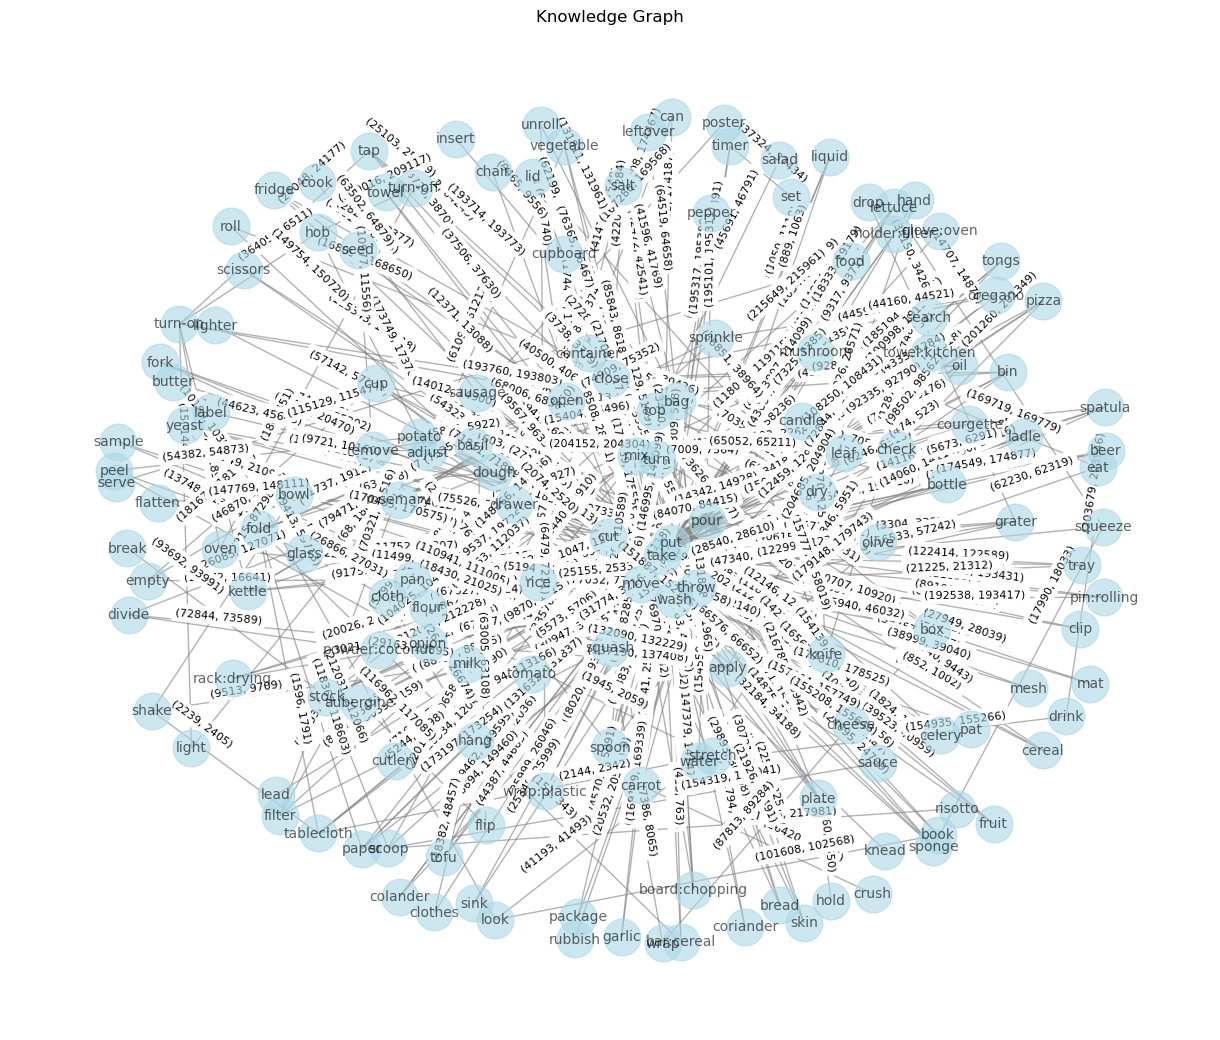

In [ ]:
pos = nx.spring_layout(G, seed=42, k=0.9)
labels = nx.get_edge_attributes(G, 'label')
plt.figure(figsize=(12, 10))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=700, node_color='lightblue', edge_color='gray', alpha=0.6)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8, label_pos=0.3, verticalalignment='baseline')
plt.title('Knowledge Graph')
plt.show()

In [ ]:
init_time = np.min([int(p.args[-1][0]) for v in predicates for p in v if p.name in ["Action", "ActionIndirect"]])
end_time = np.max([int(p.args[-1][1]) for v in predicates for p in v if p.name in ["Action", "ActionIndirect"]])

AttributeError: 'str' object has no attribute 'name'

In [ ]:
actions = {
    t: [
        p.args for v in predicates for p in v if (p.name in ["Action", "ActionIndirect"] and p.args[-1][0] <= t and p.args[-1][1] >= t)
    ] for t in range(init_time, end_time+1)
}

In [ ]:
actions

{1: [('bag', 'take', (1, 108))],
 2: [('bag', 'take', (1, 108))],
 3: [('bag', 'take', (1, 108))],
 4: [('bag', 'take', (1, 108))],
 5: [('bag', 'take', (1, 108))],
 6: [('cup', 'take', (6, 182)), ('bag', 'take', (1, 108))],
 7: [('cup', 'take', (6, 182)), ('bag', 'take', (1, 108))],
 8: [('cupboard', 'open', (8, 202)),
  ('cup', 'take', (6, 182)),
  ('bag', 'take', (1, 108))],
 9: [('cupboard', 'open', (8, 202)),
  ('cup', 'take', (6, 182)),
  ('bag', 'take', (1, 108))],
 10: [('cupboard', 'open', (8, 202)),
  ('cup', 'take', (6, 182)),
  ('bag', 'take', (1, 108))],
 11: [('cupboard', 'open', (8, 202)),
  ('cup', 'take', (6, 182)),
  ('bag', 'take', (1, 108))],
 12: [('cupboard', 'open', (8, 202)),
  ('cup', 'take', (6, 182)),
  ('bag', 'take', (1, 108))],
 13: [('cupboard', 'open', (8, 202)),
  ('cup', 'take', (6, 182)),
  ('bag', 'take', (1, 108))],
 14: [('cupboard', 'open', (8, 202)),
  ('cup', 'take', (6, 182)),
  ('bag', 'take', (1, 108))],
 15: [('cupboard', 'open', (8, 202)),


In [41]:
import torch
from torchvision import transforms
from PIL import Image
import torchvision

resnet18 = torchvision.models.resnet18(pretrained = True)

input_image = Image.open("/home/nguyennguyen/Documents/egotopo/research/P01/rgb_frames/frame_0000000006.jpg")
input_image.show()
data = np.asarray(input_image)

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    resnet18.to('cuda')

with torch.no_grad(): #Disabling gradient calculation when not calling tensor.backward()
    output = resnet18(input_batch)
# Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes
print(output[0]) #output = confidence score for each class
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

/home/nguyennguyen/anaconda3/envs/research/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nguyennguyen/anaconda3/envs/research/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)

(eog:82385): Gtk-WARNING **: 00:39:37.255: cannot open display: 


tensor([-6.4530e-01, -4.9342e-01, -5.1417e-01, -1.4465e+00, -6.3051e-01,
        -7.0760e-02, -3.8127e-01,  3.7645e-01,  1.8918e-01, -9.4571e-01,
        -1.1457e+00, -9.3956e-01, -3.7832e-01, -9.9139e-01, -1.1284e+00,
        -8.5252e-01, -9.4969e-01, -3.7365e-01, -5.3576e-01, -6.7348e-01,
        -1.7014e+00, -8.5764e-01, -1.5709e+00, -9.2968e-03, -1.1085e+00,
        -1.2498e+00, -9.0314e-01, -1.2257e+00, -9.3127e-01, -5.4291e-01,
        -9.3325e-01, -8.8022e-01, -5.2571e-01, -6.0822e-01, -3.1356e-01,
        -5.1780e-01,  5.4968e-01, -7.2539e-01, -4.7484e-01, -7.6476e-02,
        -7.4549e-01, -9.3479e-01, -1.0689e+00, -3.8871e-01, -8.1994e-01,
        -5.1186e-01, -7.9382e-01, -4.8690e-01, -1.2882e+00, -1.3102e+00,
        -6.8810e-01,  4.9336e-01, -3.9836e-01, -7.6222e-01, -2.9906e-01,
        -1.2861e+00, -4.5412e-01, -1.6235e+00, -6.4021e-01, -5.4181e-01,
         7.2033e-01,  4.2165e-02, -2.0533e-01,  6.6464e-02, -7.9915e-01,
        -2.6998e-01, -3.8979e-01, -4.9334e-01, -8.9

In [42]:
torch.min(probabilities)

tensor(6.3177e-05, device='cuda:0')

In [43]:
torch.max(probabilities)

tensor(0.0079, device='cuda:0')

In [54]:
torch.mean(probabilities) + 2*torch.std(probabilities)

tensor(0.0028, device='cuda:0')

In [55]:
np.arange(1000)[(probabilities > 0.0028).cpu()]

array([151, 412, 421, 427, 428, 447, 456, 457, 463, 469, 488, 515, 523,
       539, 541, 587, 600, 606, 618, 643, 674, 676, 696, 700, 728, 731,
       733, 749, 772, 778, 784, 792, 813, 818, 828, 836, 837, 840, 845,
       851, 852, 868, 876, 879, 898, 899, 902, 907])

In [49]:
probabilities > 0.0010

tensor([False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True,  True, False, False, False, False,  True, False,
        False, False, False, False,  True, False,  True, False, 

In [44]:
input_image.show()


(eog:82403): Gtk-WARNING **: 00:39:41.025: cannot open display: 


In [45]:
import matplotlib.pyplot as plt

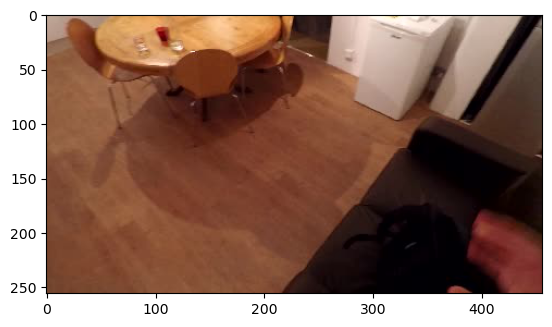

In [47]:
plt.imshow(input_image)

**YOLO V11**
Experiment with a better performing object detection model

In [20]:
import torch
import torch.nn as nn

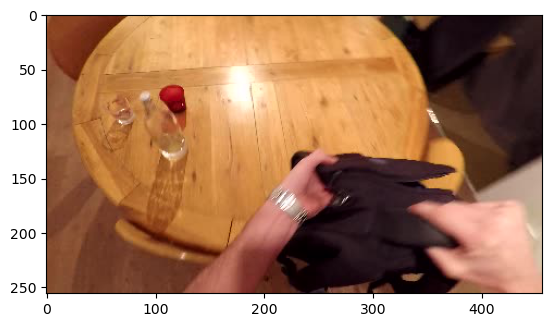

In [21]:
import matplotlib.pyplot as plt
from PIL import Image
plt.imshow(Image.open("/home/nguyennguyen/Documents/egotopo/research/P01/rgb_frames/frame_0000000400.jpg"))

In [10]:
from ultralytics import YOLO

# Load a pretrained YOLO11n model
model = YOLO("yolo11n.pt")

# Define path to the image file
source = "/home/nguyennguyen/Documents/egotopo/research/P01/rgb_frames/frame_0000000400.jpg"

# Run inference on the source
results = model(source, conf=0.1, save=True)  # list of Results objects


image 1/1 /home/nguyennguyen/Documents/egotopo/research/P01/rgb_frames/frame_0000000400.jpg: 384x640 2 persons, 1 tie, 1 cell phone, 2.3ms
Speed: 0.7ms preprocess, 2.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict19


In [23]:
results[0]

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant',

In [24]:
model.model.model

Sequential(
  (0): Conv(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (act): SiLU(inplace=True)
  )
  (1): Conv(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (act): SiLU(inplace=True)
  )
  (2): C3k2(
    (cv1): Conv(
      (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      (act): SiLU(inplace=True)
    )
    (cv2): Conv(
      (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1))
      (act): SiLU(inplace=True)
    )
    (m): ModuleList(
      (0): Bottleneck(
        (cv1): Conv(
          (conv): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
      )
    )
  )
  (3): Conv(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (act): SiLU(inplace=True)
  )
 

In [39]:
new_model = nn.Sequential(*list(model.model.model.children())[:-1])

In [27]:
cont = 0
for name, layer in model.model.model.named_modules():
    if "23" in name:
        continue
    print(name, layer)
    new_model.add_module(str(cont), layer)
    cont += 1    

 Sequential(
  (0): Conv(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (act): SiLU(inplace=True)
  )
  (1): Conv(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (act): SiLU(inplace=True)
  )
  (2): C3k2(
    (cv1): Conv(
      (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      (act): SiLU(inplace=True)
    )
    (cv2): Conv(
      (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1))
      (act): SiLU(inplace=True)
    )
    (m): ModuleList(
      (0): Bottleneck(
        (cv1): Conv(
          (conv): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
      )
    )
  )
  (3): Conv(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (act): SiLU(inplace=True)
  )


In [28]:
!pwd

/home/nguyennguyen/Documents/egotopo


In [29]:
import os

In [30]:
os.listdir()

['experiments',
 'yolo11n.pt',
 'test.ipynb',
 'ego-topo',
 'knowledge_graph.ipynb',
 'saved_model.pt',
 'epic-kitchens-55-annotations',
 '.ipynb_checkpoints',
 'preprocessing.ipynb',
 'research',
 'runs',
 'get-pip.py',
 'imagenet_classes.txt',
 'epic-kitchens-download-scripts']

In [31]:
new_model(torch.from_numpy(results[0].orig_img).to(torch.float).view(1, 3, 32*6, 32*19).cuda())

TypeError: cat() received an invalid combination of arguments - got (Tensor, int), but expected one of:
 * (tuple of Tensors tensors, int dim = 0, *, Tensor out = None)
 * (tuple of Tensors tensors, name dim, *, Tensor out = None)


In [32]:
model.model.model(torch.from_numpy(results[0].orig_img).to(torch.float).view(1, 3, 32*6, 32*19).cuda())

TypeError: cat() received an invalid combination of arguments - got (Tensor, int), but expected one of:
 * (tuple of Tensors tensors, int dim = 0, *, Tensor out = None)
 * (tuple of Tensors tensors, name dim, *, Tensor out = None)


In [33]:
456*256 / (32 * 6) / (32 * 19)

1.0

In [34]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
    

In [35]:
new_model

Sequential(
  (0): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (2): C3k2(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (m): ModuleList(
        (0): Bottleneck(
          (cv1): Conv(
            (conv): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (act): SiLU(inplace=True)
          )
        )
      )
    )
    (3): Conv(
      (conv): Conv2d(64, 64, ker

In [116]:
x = torch.from_numpy(results[0].orig_img).to(torch.float).view(1, 3, 32*6, 32*19).cuda()

In [96]:
y, dt, embeddings = [], [], []
for m in model.model.model:
    if m.f != -1:  # if not from previous layer
        x = y[m.f] if isinstance(m.f, int) else [x if j == -1 else y[j] for j in m.f]  # from earlier layers
    x = m(x)  # run
    y.append(x if m.i in model.model.save else None)  # save output

In [117]:
y, dt, embeddings = [], [], []
for m in new_model:
    if m.f != -1:  # if not from previous layer
        x = y[m.f] if isinstance(m.f, int) else [x if j == -1 else y[j] for j in m.f]  # from earlier layers
    x = m(x)  # run
    y.append(x if m.i in model.model.save else None)  # save output

In [118]:
x.shape

torch.Size([1, 256, 6, 19])

In [119]:
model.model

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (2): C3k2(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (m): ModuleList(
        (0): Bottleneck(
          (cv1): Conv(
            (conv): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (act): SiLU(inplace=True)
          )
        )
      )
    )
    (3): Conv(
      (conv): Conv2d(64,

In [120]:
fe = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.SiLU(),
            nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.SiLU(),
            nn.Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.SiLU()
        ).cuda()

In [121]:
fe(x).flatten(1).shape

torch.Size([1, 960])

In [122]:
x.flatten().shape

torch.Size([29184])

In [123]:
import copy
x1 = copy.deepcopy(x)

TypeError: prod(): argument 'input' (position 1) must be Tensor, not torch.Size

In [130]:
(x1 == x).sum() == 29184

tensor(True, device='cuda:0')

In [101]:
x1

(tensor([[[3.1384e+01, 3.4075e+01, 3.5052e+01,  ..., 4.1940e+02, 4.4832e+02, 4.5965e+02],
          [3.3479e+00, 2.3802e+00, 2.2264e+00,  ..., 1.0766e+02, 1.1251e+02, 1.2398e+02],
          [6.1099e+01, 7.6093e+01, 9.4408e+01,  ..., 3.9536e+02, 3.6699e+02, 3.6947e+02],
          ...,
          [6.9517e-20, 7.5285e-28, 5.4674e-29,  ..., 1.5718e-11, 4.3893e-09, 2.0453e-10],
          [2.6906e-12, 4.7433e-18, 3.4007e-19,  ..., 3.4745e-08, 4.5690e-07, 5.9681e-08],
          [2.9137e-13, 1.3349e-19, 2.5595e-20,  ..., 5.5179e-11, 1.9632e-09, 1.0500e-09]]], device='cuda:0'),
 [tensor([[[[ 11.0844,   7.4458, -12.9723,  ..., -12.3250, -27.6120, -21.5235],
            [  3.7556, -12.5999, -36.9448,  ..., -14.3402, -12.2580, -11.0903],
            [ -7.8862, -26.4224, -56.4520,  ..., -25.4789, -25.5339, -26.3179],
            ...,
            [  6.5780,   3.1845, -28.7739,  ..., -22.5836, -18.2529, -20.0816],
            [ -4.0105,  -7.9545, -22.6732,  ..., -15.8942, -23.2469, -33.6194],
        

In [102]:
x

tensor([[[[-1.2721e-01, -2.0799e-02, -9.6739e-02,  ..., -1.6260e-02, -1.7316e-03, -2.2686e-06],
          [-1.9989e-01, -2.2461e-03, -7.7402e-02,  ..., -2.2383e-02, -3.5824e-02, -1.5708e-05],
          [-8.8849e-03, -6.4775e-03, -1.0236e-01,  ..., -1.7521e-01, -1.0300e-01, -1.4863e-03],
          [-1.3677e-01, -1.0511e-01,  4.2269e+00,  ..., -1.9652e-02, -8.0321e-02, -5.3404e-05],
          [-2.5771e-01,  3.1148e-02,  1.5398e-01,  ..., -4.7085e-03, -8.1690e-04, -4.0031e-05],
          [-2.6564e-01, -1.1844e-01, -1.7984e-02,  ...,  1.5934e+00, -2.3533e-01, -1.5933e-02]],

         [[-1.9625e-03, -5.0044e-04, -1.0255e-04,  ..., -1.7954e-02, -2.7731e-01,  5.2288e-01],
          [-1.4738e-02,  1.7924e+00, -6.7414e-07,  ..., -5.1932e-02, -3.2659e-04, -7.8593e-10],
          [ 9.1358e+00, -6.7850e-02, -8.0527e-05,  ..., -9.9184e-05, -2.9249e-11, -3.9842e-10],
          [-2.0932e-04, -2.4944e-04, -3.6983e-16,  ..., -2.7287e-09, -7.8298e-04, -3.7751e-05],
          [-1.4303e-01, -2.6326e-04, -

In [103]:
new_model

Sequential(
  (0): Conv(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (act): SiLU(inplace=True)
  )
  (1): Conv(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (act): SiLU(inplace=True)
  )
  (2): C3k2(
    (cv1): Conv(
      (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      (act): SiLU(inplace=True)
    )
    (cv2): Conv(
      (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1))
      (act): SiLU(inplace=True)
    )
    (m): ModuleList(
      (0): Bottleneck(
        (cv1): Conv(
          (conv): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
      )
    )
  )
  (3): Conv(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (act): SiLU(inplace=True)
  )
 

In [115]:
for name, layer in new_model.named_modules():
    for name1, layer1 in model.model.model.named_modules():
        if name == name1 and "conv" in name:
            with torch.no_grad():
                layer.weight = layer1.weight

In [112]:
for name, layer in model.model.model.named_modules():
    print(name)


0
0.conv
0.act
1
1.conv
2
2.cv1
2.cv1.conv
2.cv2
2.cv2.conv
2.m
2.m.0
2.m.0.cv1
2.m.0.cv1.conv
2.m.0.cv2
2.m.0.cv2.conv
3
3.conv
4
4.cv1
4.cv1.conv
4.cv2
4.cv2.conv
4.m
4.m.0
4.m.0.cv1
4.m.0.cv1.conv
4.m.0.cv2
4.m.0.cv2.conv
5
5.conv
6
6.cv1
6.cv1.conv
6.cv2
6.cv2.conv
6.m
6.m.0
6.m.0.cv1
6.m.0.cv1.conv
6.m.0.cv2
6.m.0.cv2.conv
6.m.0.cv3
6.m.0.cv3.conv
6.m.0.m
6.m.0.m.0
6.m.0.m.0.cv1
6.m.0.m.0.cv1.conv
6.m.0.m.0.cv2
6.m.0.m.0.cv2.conv
6.m.0.m.1
6.m.0.m.1.cv1
6.m.0.m.1.cv1.conv
6.m.0.m.1.cv2
6.m.0.m.1.cv2.conv
7
7.conv
8
8.cv1
8.cv1.conv
8.cv2
8.cv2.conv
8.m
8.m.0
8.m.0.cv1
8.m.0.cv1.conv
8.m.0.cv2
8.m.0.cv2.conv
8.m.0.cv3
8.m.0.cv3.conv
8.m.0.m
8.m.0.m.0
8.m.0.m.0.cv1
8.m.0.m.0.cv1.conv
8.m.0.m.0.cv2
8.m.0.m.0.cv2.conv
8.m.0.m.1
8.m.0.m.1.cv1
8.m.0.m.1.cv1.conv
8.m.0.m.1.cv2
8.m.0.m.1.cv2.conv
9
9.cv1
9.cv1.conv
9.cv2
9.cv2.conv
9.m
10
10.cv1
10.cv1.conv
10.cv2
10.cv2.conv
10.m
10.m.0
10.m.0.attn
10.m.0.attn.qkv
10.m.0.attn.qkv.conv
10.m.0.attn.qkv.act
10.m.0.attn.proj
10.m.0.attn.pro

In [3]:
!pwd

/home/nguyennguyen/Documents/egotopo


In [7]:
"""Examine yolov11n after training on localization task"""
import torch

yolo11n_path = "/home/nguyennguyen/Documents/egotopo/experiments/yolo-egotopo/build_graph/localization_network/cv/epic/ckpt_E_10_I_770_L_0.649_A_0.626.pth"

model = torch.load(yolo11n_path) 
model


/tmp/ipykernel_14351/2020093685.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(yolo11n_path)


{'net': OrderedDict([('yolo.0.conv.weight',
               tensor([[[[-0.1331, -0.0187,  0.1724],
                         [-0.3369, -0.0443,  0.3555],
                         [-0.2374, -0.0192,  0.2656]],
               
                        [[-0.1577, -0.0229,  0.1974],
                         [-0.4104, -0.0664,  0.3970],
                         [-0.2051, -0.0076,  0.2502]],
               
                        [[-0.0528, -0.0099,  0.0448],
                         [-0.1619, -0.0060,  0.1525],
                         [-0.0764,  0.0158,  0.0967]]],
               
               
                       [[[-0.1992, -0.1359, -0.0448],
                         [-0.1913, -0.2133, -0.1317],
                         [-0.0863, -0.1149, -0.0537]],
               
                        [[ 0.0977,  0.0469,  0.0242],
                         [ 0.0573,  0.0327,  0.0198],
                         [ 0.0142, -0.0076, -0.0123]],
               
                        [[ 0.1155,  0.0930, 